# Severstal steel defect detection Kaggle competition
# Queensland AI HUB FAST AI course 2021
## Group CV9-online
* Muhammad Bilal
* Jose Varela
* Carlos Orjuela
* Jan Sobus

# Competition information

The competition description is available [here](https://www.kaggle.com/c/severstal-steel-defect-detection) 

# 1. Data preparation


* If you do not have the **fastai library** you may install it with `pip install -Uqq fastai`
* If you do not have the **kaggle API** installed and configured:
    * run `pip install kaggle` 
    * verify your phone in the account page https://www.kaggle.com/me/account
    * sign out of kaggle
    * sign back in to kaggle to generate the token from a verified session
    * generate the token from the account page and save it locally see https://github.com/Kaggle/kaggle-api#api-credentials
* To be able to **download the severstal data**, you will currently need to:
    * have a token generated from a session with a verified phone number in kaggle (after verifying your phone sign out and sign back in to kaggle)
    * join the Severstal competition 
    * accept the rules in the competition data download page https://www.kaggle.com/c/severstal-steel-defect-detection/data
    * and only then run `kaggle competitions download -c severstal-steel-defect-detection -p /data/datasets/severstal`

In [2]:
#Imports

from fastai.vision.all import *
from tqdm.auto import tqdm
from IPython.display import HTML
from pathlib import Path
import zipfile

In [ ]:
YOURPATH = #path to the directory you downloaded the dataset zip to
path = Path(YOURPATH)
zf_path = path / "severstal-steel-defect-detection.zip"


with zipfile.ZipFile(zf_path, 'r') as zip_ref:
     zip_ref.extractall(path)

path.ls()

Since the labels for the training and test set are encoded in csv files (see [here](https://www.kaggle.com/c/severstal-steel-defect-detection/overview/evaluation) we need a function that will turn those into masks that can be used as a ground truth for segmentation.

**QUICK NOTE - use PNG for masks, not JPG, since in our first trial with JPG the compression messed the masks up**

In [ ]:
def generate_masks(path):
    (path/"codes.txt").write_text("\n".join(['Background','Divots','Cracks','Scratches','Ablations']))
    masks_path=path / "masks"
    masks_path.mkdir(exist_ok=True)
    mask_files_progress = tqdm(get_image_files(path/'train_images'), position=1, desc=f"Generating train masks: ")
    df = pd.read_csv(path/'train.csv')
    current_file_display = display(display_id=True)
    im_sz = (1600, 256)
    for fn in mask_files_progress:
        current_file_display.update(HTML(f"&nbsp;<small>Saving {path/'masks'/fn.name}...</small>"))
        im = np.zeros(im_sz[0]*im_sz[1], dtype=np.uint8)
        for c in range(1, 5):
            rle_pixels = df[(df["ImageId"]==fn.name) & (df["ClassId"]==c)]["EncodedPixels"].values
            if len(rle_pixels) > 0:
                rle_numbers = [int(numstring) for numstring in rle_pixels[0].split(' ')]
                rle_pairs = np.array(rle_numbers).reshape(-1, 2)
                for index, length in rle_pairs:
                    index -= 1
                    im[index:index+length] = c
        im = Image.fromarray(im.reshape(im_sz).T)
        im.save(f'{masks_path}/{fn.stem}.png')
    current_file_display.update(HTML(f"&nbsp;<small>All done!</small>"))

generate_masks(path)

We can then quickly build a basic dataloader and see how the data looks like:

In [5]:
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"train_images"),
    label_func = lambda o: path/'masks'/f'{o.stem}.png',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

In [6]:
batch = dls.one_batch()
batch[0].shape, batch[1].shape

(torch.Size([8, 3, 256, 1600]), torch.Size([8, 256, 1600]))

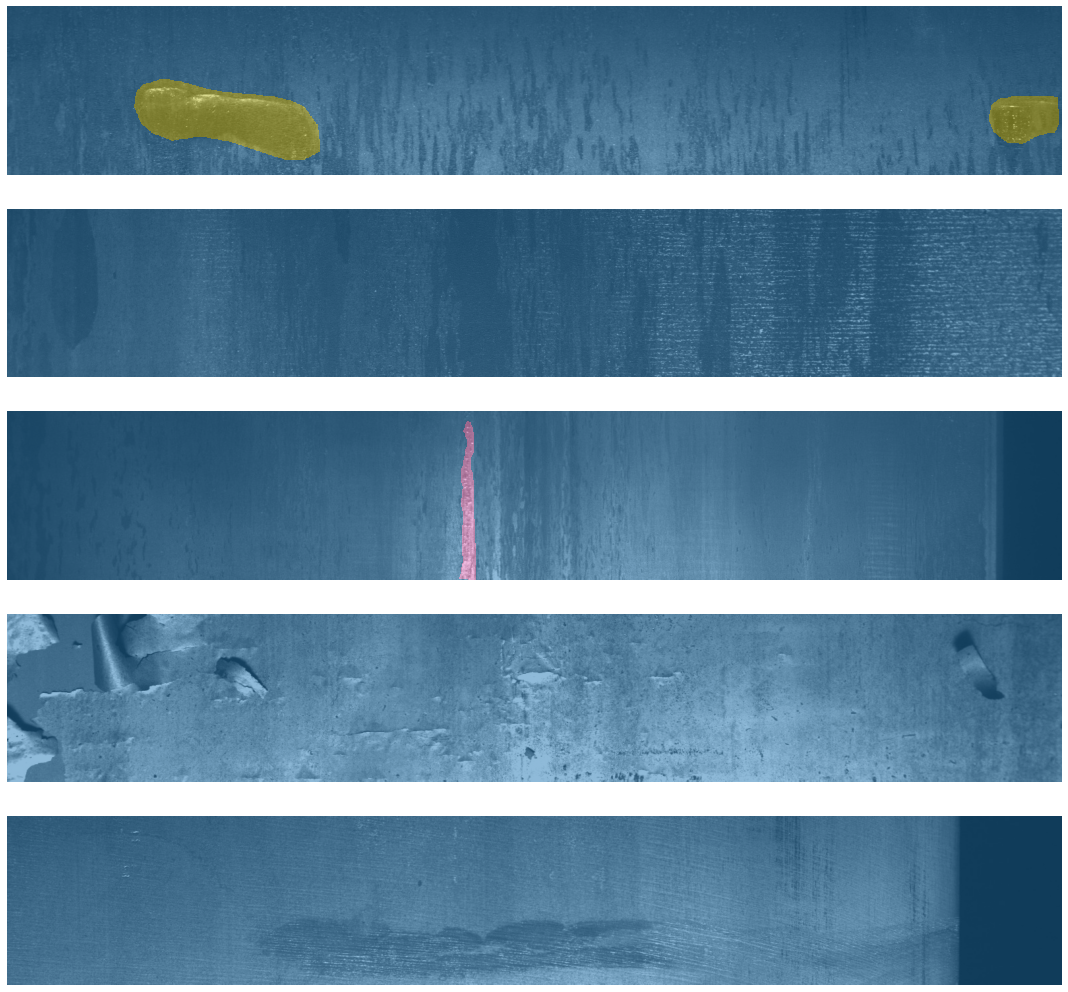

In [7]:
dls.show_batch(max_n=5, nrows=5, figsize=(30,18))

# 2. Exploratory data analysis

We wanted some more information about our dataset - how balanced it is, how many classes we need to predict, what's the typical defect size etc

In [8]:
#More imports 
import pandas as pd
import numpy as np
# from fastai.vision.all import *

# from fastai.vision.core import PILImage, PILMask
# from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
# from PIL import Image

In [11]:
#Reading the info on the training masks
df = pd.read_csv(path/'train.csv')
#Calculating defect areas in px
df['DefectArea']=df['EncodedPixels'].apply(lambda ep: np.array(ep.split()[1::2]).astype('int').sum())
df.head(3)

,ImageId,ClassId,EncodedPixels,DefectArea
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 30370 24 30626 24 30882 24 31139 23 31395 23 31651 23 31907 23 32163 23 32419 23 32675 23 77918 27 78174 55 78429 60 78685 64 78941 68 79197 72 79452 77 79708 81 79964 85 80220 89 80475 94 80731 98 80987 102 81242 105 81498 105 81754 104 82010 104 82265 105 82521 31 82556 69 82779 27 82818 63 83038 22 83080 57 83297 17 83342 50 83555 13 83604 44 83814 8 83866 37 84073 3 84128 31 84390 25 84652 18 84918 8 85239 10 85476 29 85714 47 85960 57 86216 57 86471 58 86727 58 86983 58 87238 59 87494 59 87750 59 88005 60 88261 60 88517 60 88772 61 89028 53...,4396
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 110 19859 110 20115 110 20371 110 20627 110 20883 110 21139 110 21395 110 21651 110 21962 55 293125 251 293381 251 293637 251 293893 251 294149 251 294405 251 294661 251 294917 251 295173 251 295429 251 295685 251 295941 251 296197 251 296453 251 296709 251 296965 251 297221 251 297477 251 297733 251 297989 251 298245 251 298564 188 298945 63,6897
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 38863 28 39119 28 39375 29 39631 29 39887 29 40143 29 40399 29 40655 30 40911 30 41167 30 41423 30 41679 31 41935 31 42191 31 42447 31 42703 31 42960 31 43216 31 43472 31 43728 31 43984 31 44240 32 44496 32 44752 32 45008 32 45264 33 45520 33 45776 33 46032 33 46288 33 46544 34 46803 31 47065 25 47327 19 47588 15 47850 9 48112 3 62667 12 62923 23 63179 23 63348 3 63435 23 63604 7 63691 23 63860 11 63947 23 64116 15 64203 23 64372 19 64459 23 64628 24 64715 23 64884 28 64971 23 65139 33 65227 23 65395 37 65483 23 65651 41 65740 22 65907 45 65996 22...,8319


## a. Relative frequency of defects

Many more "Scratches" than other types of defects

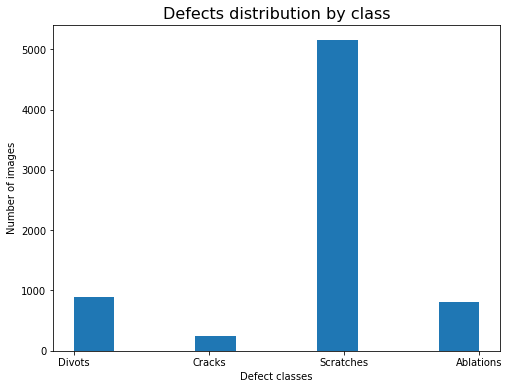

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.hist(df.ClassId)
ax.set_title("Defects distribution by class", fontsize=16)
ax.set_ylabel('Number of images')
ax.set_xlabel('Defect classes')
ax.set_xticks(np.array([1,2,3,4]))
xlabels = ['Divots','Cracks','Scratches','Ablations']
ax.set_xticklabels(xlabels, fontsize=10)
plt.show()

In [13]:
summary = df.groupby(['ImageId','ClassId']).agg({'DefectArea':['count','sum']}).unstack('ClassId').fillna(0).astype(int)
summary.columns = ['Divots','Cracks','Scratches','Ablations', 'DivotsArea','CracksArea','ScratchesArea','AblationsArea']
summary['TotalDefects'] = summary.loc[:,'Divots':'Ablations'].sum(axis=1)
summary['TotalArea'] = summary.loc[:,'DivotsArea':'AblationsArea'].sum(axis=1)
summary

,Divots,Cracks,Scratches,Ablations,DivotsArea,CracksArea,ScratchesArea,AblationsArea,TotalDefects,TotalArea
ImageId,,,,,,,,,,
0002cc93b.jpg,1,0,0,0,4396,0,0,0,1,4396
0007a71bf.jpg,0,0,1,0,0,0,6897,0,1,6897
000a4bcdd.jpg,1,0,0,0,8319,0,0,0,1,8319
000f6bf48.jpg,0,0,0,1,0,0,0,69357,1,69357
0014fce06.jpg,0,0,1,0,0,0,4851,0,1,4851
...,...,...,...,...,...,...,...,...,...,...
ffcf72ecf.jpg,0,0,1,0,0,0,8903,0,1,8903
fff02e9c5.jpg,0,0,1,0,0,0,7206,0,1,7206
fffe98443.jpg,0,0,1,0,0,0,2336,0,1,2336


## b. image statistics

### Pretty balanced dataset when it comes to defect/no defect distinction

In [14]:
train_images= get_image_files(path/'train_images')
num_images = len(train_images)
images_with_defects = len(np.unique(df.ImageId))
images_without_defects = num_images - images_with_defects
print(f'There are {num_images} images. {images_with_defects} ({round((images_with_defects/num_images)*100,2)}%) of which have defects while remaining {images_without_defects} ({round((images_without_defects/num_images)*100,2)}%) are defectless.')

There are 12568 images. 6666 (53.04%) of which have defects while remaining 5902 (46.96%) are defectless.


### Most of the time single defect class in the image

In [15]:
summary['TotalDefects'].value_counts()

1    6239
2     425
3       2
Name: TotalDefects, dtype: int64

### Verify that masks are generated correctly

In [19]:
masks = get_image_files(path/'masks')
uniques = [tuple(np.unique(array(Image.open(m)))) for m in masks]
np.unique(uniques, return_counts=True)

(array([(0,), (0, 1), (0, 1, 2), (0, 1, 2, 3), (0, 1, 3), (0, 2),
        (0, 2, 3), (0, 2, 4), (0, 3), (0, 3, 4), (0, 4)], dtype=object),
 array([5902,  769,   35,    2,   91,  195,   14,    1, 4759,  284,  516]))

0 labels pixels without defect and 1-4 label particular defect classes. One can see that there are 5902 masks without defects as expected, 2 masks with 3 different defects etc - **masks were generated correctly**

## c. comparing global dataset stats with imagenet stats

This will be useful for the augmentation step, since the images are normalised using the mean and std value per RGB channel

### Calculating Severstal values

In [22]:
codes = ["Background", "Divots", "Cracks", "Scratches", "Ablation"]
dblock = DataBlock(blocks=(ImageBlock(PILImageBW), MaskBlock(codes)),
                   get_items=get_image_files,
                   get_y = lambda o: path/'masks'/f'{o.stem}.png',
)
dls=dblock.dataloaders(path/'train_images', bs=4)


def get_mean_std(ds):
    channels_sum, channels_squared_sum, num_batches = 0., 0., 0.
    for xb, yb in ds:
      # VAR[x] = E[X**2] - E[X]**2
      channels_sum += torch.mean(xb, dim=[0,2,3])
      channels_squared_sum += torch.mean(xb**2, dim=[0,2,3])
      num_batches += 1

    mean = channels_sum/num_batches
    std  = (channels_squared_sum/num_batches - mean**2)**0.5
    print(mean,std)
    return ([round(mean.item(),3)]*3, [round(std.item(),3)]*3)

severstal_stats = get_mean_std(dls.train)
severstal_stats

TensorImageBW([0.3430], device='cuda:0') TensorImageBW([0.1949], device='cuda:0')


([0.343, 0.343, 0.343], [0.195, 0.195, 0.195])

Not surprisingly the per-channel values are the same, since images are in grayscale.

In [23]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

**Observation:** It is obvious that severstal dataset's stats are not similar to that of imagenet. We better use severstal stats for dataset normalization.

## d. Looking at the samples of defects of each type

First, let's identify pictures with multiple defect classes:

In [24]:
df_multi_def = df[['ClassId', 'ImageId']].groupby('ImageId').count()
df_multi_def.reset_index(level=0, inplace=True)
df_multi_def.columns = ['ImageId', 'classes_count']
df_multi_def[df_multi_def.classes_count>1]

,ImageId,classes_count
5,0025bde0c.jpg,2
7,002fc4e19.jpg,2
16,008ef3d74.jpg,2
18,00ac8372f.jpg,2
22,00c88fed0.jpg,2
...,...,...
6587,fd26ab9ad.jpg,2
6605,fdb7c0397.jpg,2
6617,fe2234ba6.jpg,2
6651,ff6bfada2.jpg,2


In [25]:
df_count = df.merge(df_multi_def, on='ImageId', how='left')[['ImageId', 'ClassId', 'classes_count']]

Now, let's get some random samples of every ClassId and exclusively for that class. Every execution will generate a set of samples:

In [26]:
samples_dict = dict()
sample_size = 3

for classid in df.ClassId.unique():
    samples_dict[classid] = random.sample(list(df_count[(df_count['ClassId'] == classid) 
                                                        & (df_count['classes_count'] == 1)]['ImageId'].values), sample_size)

Let's create a simple dictionary with the defect names:

In [27]:
defects = dict(zip(np.arange(4)+1 ,['Divots','Cracks','Scratches','Ablations']))

In [28]:
def plot_samples(sample_class = 1, masks_alpha = 0.3, fig_size=(24,6)):
    # Function to plot the images, mask and superimposed version side by side
    #TODO: use a loop to iterate over the whole dict
    tmask = Transform(PILMask.create)

    fig,axs = plt.subplots(nrows=sample_size, ncols=3, figsize=fig_size)#gridspec_kw=dict(left=0.1, right=0.9, bottom=0.1, top=0.9))

    fig.subplots_adjust(hspace=0.5)
    fig.suptitle(f'Samples - {defects[sample_class]}')

    for pos, pic in enumerate(samples_dict[sample_class]):
        train_img = PILImage.create(path/'train_images'/pic)
        mask = tmask(f'{path}/masks/{Path(pic).stem}.png')

        axs[pos,0].imshow(train_img); axs[pos,0].set(title='image')
        axs[pos,1].imshow(mask, alpha=1); axs[pos,1].set(title='mask')
        axs[pos,2].imshow(train_img)
        axs[pos,2].imshow(mask, alpha=masks_alpha); axs[pos,2].set(title='superimposed')

    plt.setp(axs, xticks=[], yticks=[])
    plt.show()

Now, let's see the samples per defect class:

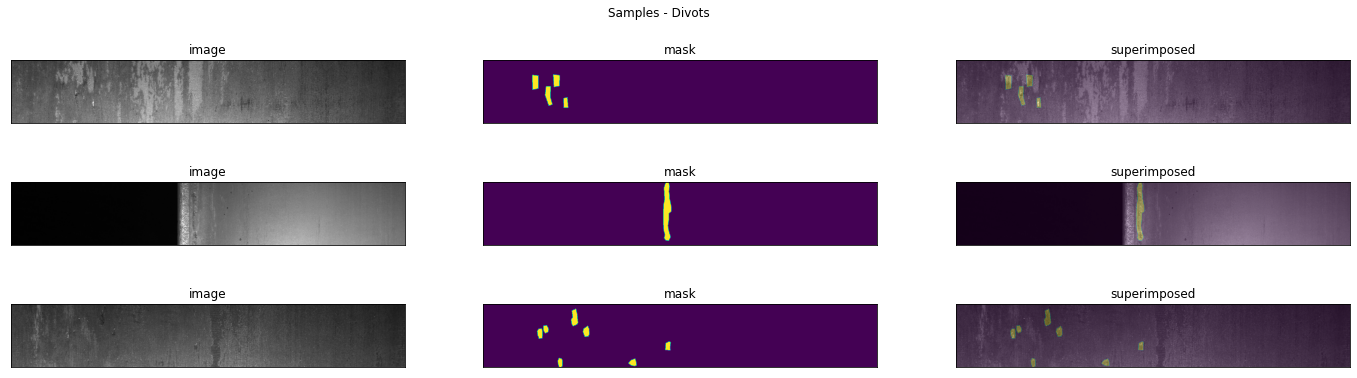

In [33]:
plot_samples(1)

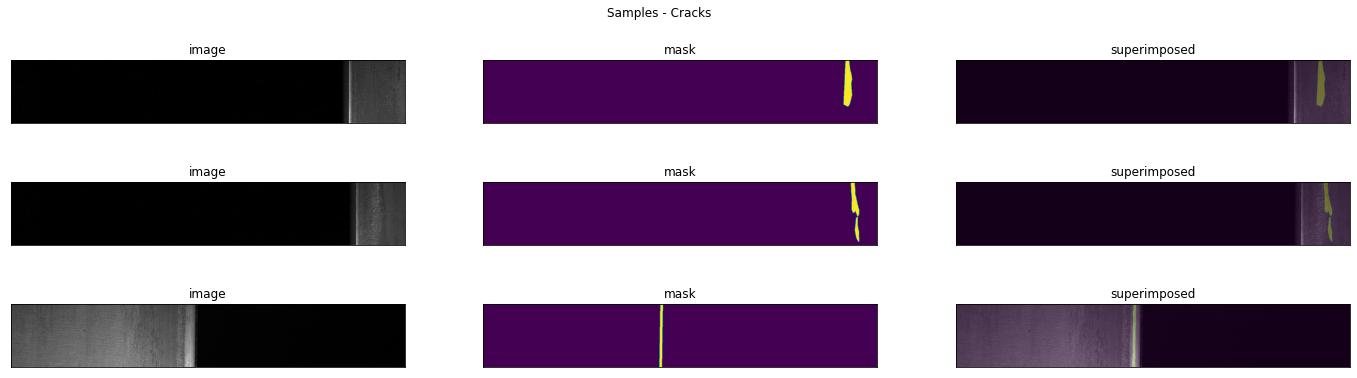

In [34]:
plot_samples(2)

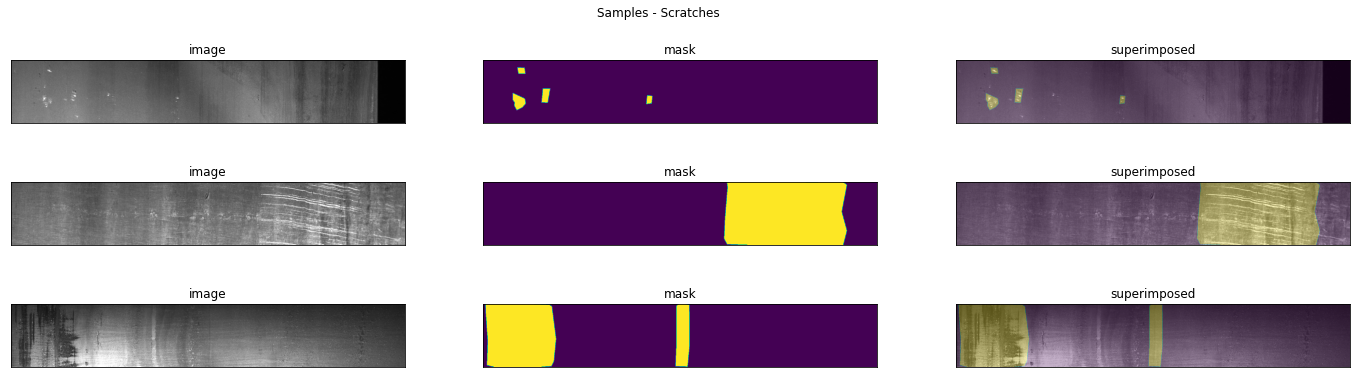

In [35]:
plot_samples(3)

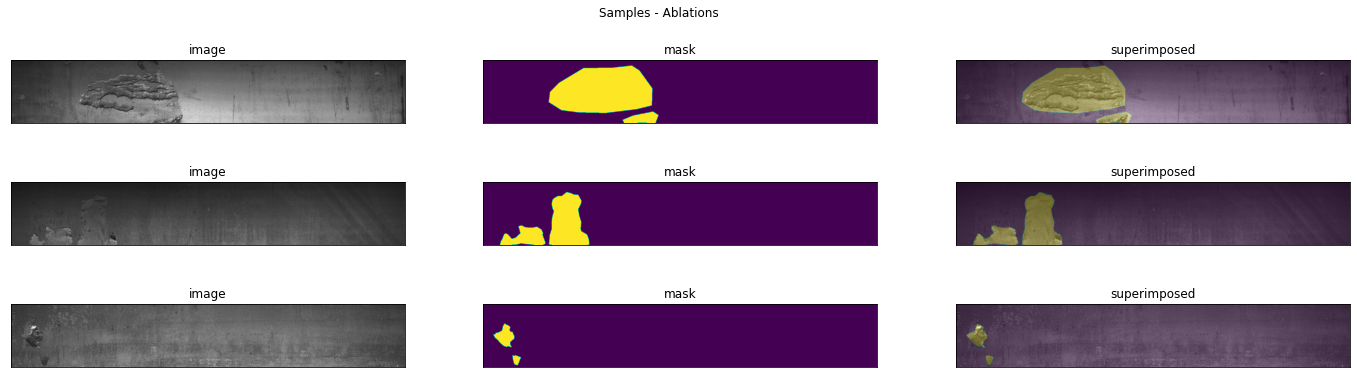

In [36]:
plot_samples(4)

# 3. Model training

## a. Baseline model

Let's load the dataloaders again

In [37]:
codes = ["Background", "Divots", "Cracks", "Scratches", "Ablation"]
dblock = DataBlock(blocks=(ImageBlock(PILImageBW), MaskBlock(codes)),
                   get_items=get_image_files,
                   get_y = lambda o: path/'masks'/f'{o.stem}.png',
)
dls=dblock.dataloaders(path/'train_images', bs=4)

Since it's a segmentation problem we will use unet_learner from FastAI with Dice score as a metric (which is also used for competition evaluation)

In [40]:
learn = unet_learner(dls, resnet34, metrics=[DiceMulti])
learn.fine_tune(5)

epoch,train_loss,valid_loss,dice_multi,time
0,0.079481,0.079155,0.293041,15:27


epoch,train_loss,valid_loss,dice_multi,time
0,0.070288,0.068478,0.405620,15:58
1,0.062014,0.051522,0.478925,15:58
2,0.043960,0.050328,0.535492,15:57
3,0.037526,0.044740,0.572474,15:58
4,0.032088,0.045638,0.642000,16:01


We'll see ways to improve that score below

## b. Loss functions

Basic loss function used by the learner is `CrossEntropyLossFlat` . It doesn't exactly follow the metric that we want to maximize (Dice Score - which is equivalent to pixel wise F1 score, more on segmentation metrics [here](https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2)). Therefore we introduced Dice Loss which is 1 - Dice Score

In [41]:
class DiceLoss:
    "Dice loss for segmentation"
    def __init__(self, axis=1, smooth=1):
        store_attr()
    def __call__(self, pred, targ):
        targ = self._one_hot(targ, pred.shape[self.axis])
        pred, targ = flatten_check(self.activation(pred), targ)
        inter = (pred*targ).sum()
        union = (pred+targ).sum()
        return 1 - (2. * inter + self.smooth)/(union + self.smooth)
    @staticmethod
    def _one_hot(x, classes, axis=1):
        "Creates one binay mask per class"
        return torch.stack([torch.where(x==c, 1, 0) for c in range(classes)], axis=axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)
    def decodes(self, x):    return x.argmax(dim=self.axis)

Since the Dice Loss is not very good at grabbing really small defects, we coupled it with the Focal Loss (which is Cross Entropy Loss weighted strongly for difficult examples) creating combined Combo Loss

In [42]:
class CustomComboLoss:
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1., alpha=0.25):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth)       
    def __call__(self, pred, targ):
        return (self.alpha * self.focal_loss(pred, targ)) + ((1-self.alpha) * self.dice_loss(pred, targ))
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

More sophisticated loss functions are being used (see [here](https://arxiv.org/pdf/2006.14822.pdf)) but given limited time we didn't bring them to FAST AI, maybe will do that in the future.

There is also a caveat regarding Dice score/loss - depending on the implementation it can vary from the definition in the multiclass case - see our post with examples [here](https://github.com/BloodAxe/pytorch-toolbelt/issues/59).

## c. Augmentations

We resize the images and apply some common image augmentations, followed by normalizing with the dataset stats

In [ ]:
batch_tfms=[*aug_transforms(size=(256,512),flip_vert=True), Normalize.from_stats(*severstal_stats)]

## d. Activation function

We replace the default `ReLU` function with the `Mish` function decribed [here](https://arxiv.org/pdf/1908.08681.pdf), which results in better model convergence.

In [ ]:
act_cls=Mish

## e. Bigger model

`Resnet34` might not be able to capture all the features in the data, so we move to `Resnet50`

## f. Callbacks

We use 2 different callbacks here:
* `GradientAccumulation` Since our batch size is small we risk high gradient jumps around the true minimum.
   Therefore we use that callback to only update gradients every 4 batches
* `ReduceLROnPlateau` Since finding the good LR and updating it every few epochs can be tedious, 
   we use this callback to automatically reduce it when the model stops improving. That way we can run more epochs    simultaneously 

In [ ]:
cbs = [GradientAccumulation(n_acc=24),ReduceLROnPlateau(factor=4,patience=2, min_lr=1e-9)]

## g. Optimizer

We changed the default `Adam` optimizer to `ranger` which is a combination of `RectifiedAdam` wrapped in the `Lookahead` class  (https://docs.fast.ai/optimizer.html)

In [ ]:
opt_func=ranger

## h. FP Precision

We reduced the precision of floats in our model using `.to_fp16()` method. With `Adam` that was causing some problems with NaNs in the metrics and losses, but `ranger` seems to have gradients civilized enough to avoid that problem.

## i. Learning rate tuning

* We use `lr_find` to find the optimal LR for the frozen and unfrozen parts of training
* We use LR slicing to have higher LR in the layers close to the model head and smaller at early ones
* We use [cosine_annealing](https://towardsdatascience.com/https-medium-com-reina-wang-tw-stochastic-gradient-descent-with-restarts-5f511975163), might try SGDR too

## j. Preprocessing model

Around half of the images in the training set don't have any defects. Their use in training for the segmentation model is limited and they may bring some bias. However, we can make a pipeline that first applies binary classifier to the whole image (0 - no defects in the image, 1 - defects in the image) and only if there are defects present, it passes the image to the segmentation model. If we assume that such preclassifier takes care of "empty" images, we can train segmentation model only on the images with defects, speeding things up and making it more precise (hopefully). We update `get_items` function in the `Datablock`to achieve that:

In [ ]:
def get_mask(fn):
    fn = Path(str(fn).replace('train_images', 'masks').replace('jpg','png'))
    return PILMask.create(fn)

def get_images_with_defects(path):
    L = get_image_files(path)
    L = [p for p in L if np.max(np.array(get_mask(p))) > 0]
    return L

## k. Maintaining the class distribution in train and val sets

Since FastAI uses the RandomSplitter by default, there is a risk that there will be different distribution of classes in the training and validation set. We take care of that problem by writing our own splitter utilising sklearn train_test_split and using least common class in the mask as a stratifying parameter.

In [ ]:



def StratMaskSplitter(test_size=0.2, random_state=None, train_size=None, shuffle=True):
    "Split `items` into random train and test stratifying by smallest defect in the mask"
    
    def get_smallest_label(mask):
        vals, counts = tensor(mask).unique(return_counts=True)
        return vals[torch.argmin(counts)]
    
    def _inner(o, **kwargs):
        
        labels = tensor([get_smallest_label(get_mask(fn)) for fn in o])       
        
        train,valid = train_test_split(range_of(o), test_size=test_size, random_state=random_state,
                                        stratify=labels, train_size=train_size, shuffle=shuffle)
        return L(train), L(valid)
    return _inner

## l. Final score

Final model trained with the code below reached the `dicemulti` score of 70% on a set of only images with defects, which would translate to even higher score on the full set.

**Interactive model demo is accessible [here](insert_link)**

In [ ]:
severstal_stats=([0.343], [0.197])

dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                     get_items=get_images_with_defects,
                     get_y = get_mask,
                     splitter = StratMaskSplitter(),
                     batch_tfms=[*aug_transforms(size=(256,512),flip_vert=True), Normalize.from_stats(*severstal_stats)])

dls_strat = dblock.dataloaders(path/'train_images', batch_size=6)


learn = unet_learner(dls_strat, resnet50, loss_func=CustomComboLoss(alpha=0.5), metrics=[DiceMulti], opt_func=ranger, act_cls=Mish, cbs=[GradientAccumulation(n_acc=24)],self_attention = True).to_fp16()

learn.lr_find()

learn.fit_flat_cos(10, slice(1e-4))

learn.unfreeze()
learn.lr_find()

lr = 1e-5
lrs = slice(lr/100, lr)
learn.fit_flat_cos(10, lrs, cbs = [GradientAccumulation(n_acc=24),ReduceLROnPlateau(factor=4,patience=2, min_lr=1e-9)])



# 4 Preprocessing classifier

Getting the list of image names with defects:

In [44]:
defected_list = list(df.ImageId.unique())

Defining a function to get the categories `defect/no defect` as 1 and 0 respectively:

In [45]:
def name_in_list(image_name):
    if image_name in defected_list:
        return 1
    else:
        return 0

Now, it comes the DataBlock definition. The selected method for the first resizing was `squish` as random crop might get relevant sections of the image (i.e. parts with defects on it) out of the frame, compounded by the fact the image ratio size is significant. (_TODO:_ `pad` might be a better option if there's a way to use `pad_mode=reflection` as shown in https://docs.fast.ai/vision.augment#Resize):

In [46]:
images = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 get_y=using_attr(name_in_list, 'name'),
                 item_tfms=Resize(1600, method='squish'),
                 batch_tfms=aug_transforms(size=700, min_scale=0.8)
                  )
dls_img = images.dataloaders(path/"train_images", batch_size=32)
learn_pre = cnn_learner(dls_img, resnet34, metrics=error_rate)

/home/fireball/miniconda3/envs/pytorch/lib/python3.8/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=tensor(0.0014))

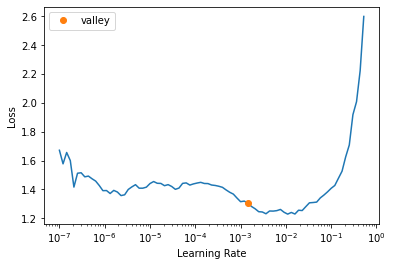

In [47]:
learn_pre.lr_find()

In [48]:
learn_pre.fine_tune(12, base_lr=1e-04)

epoch,train_loss,valid_loss,error_rate,time
0,0.755446,0.443015,0.201353,03:58


epoch,train_loss,valid_loss,error_rate,time
0,0.639309,0.361785,0.162356,04:24
1,0.530786,0.310916,0.141663,04:24
2,0.500410,0.254430,0.106645,04:24
3,0.388271,0.226705,0.092718,04:24
4,0.360048,0.205828,0.079188,04:25
5,0.323563,0.197025,0.072423,04:24
6,0.296120,0.189744,0.069240,04:24
7,0.272388,0.193165,0.069240,04:24
8,0.257778,0.170500,0.063271,04:24
9,0.244156,0.170122,0.060883,04:24


94% percent accuracy is not bad for initial preclassifier and if we set the threshold properly we can assure Recall rate close to 100% (all the images with defects will be forwarded to the segmentation model 

# 5 Things that didn't work out

## a. Greyscale model

Since our images are in grayscale, with all 3 RGB channels having the same information, it's only natural to try a model with a single input channel (that would hopefully saved memory and sped up the training). We build the dataloaders, but the model didn't perform very well.

In [ ]:



def get_grayscale(fn):
    return np.array(Image.open(fn))[...,0]


def get_dls_gray(size, batch_size=8):
  
  dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                     get_items=get_image_files, #or get_images_with_defects
                     get_x=get_grayscale,
                     get_y = get_mask,
                     batch_tfms=[*aug_transforms(size=size,flip_vert=True), Normalize.from_stats(*severstal_stats)])
  
  return dblock.dataloaders(path/'train_images', batch_size=batch_size)

dls_gray = get_dls_gray()

unet_learner(dls_gray, resnet34, n_in=1)

## b. EfficientNet backbone

Since Efficient Nets have been proven to obtain same level off efficiency as Resnets with a lot less parameters, we tried using EfficientNetB3 from [TIMM](https://github.com/rwightman/pytorch-image-models) as the model backbone but for some reason the best result was around 57% (using other tricks shown above).

In [ ]:
from timm import create_model

def _update_first_layer(model, n_in, pretrained):
    "Change first layer based on number of input channels"
    if n_in == 3: return
    first_layer, parent, name = _get_first_layer(model)
    assert isinstance(first_layer, nn.Conv2d), f'Change of input channels only supported with Conv2d, found {first_layer.__class__.__name__}'
    assert getattr(first_layer, 'in_channels') == 3, f'Unexpected number of input channels, found {getattr(first_layer, "in_channels")} while expecting 3'
    params = {attr:getattr(first_layer, attr) for attr in 'out_channels kernel_size stride padding dilation groups padding_mode'.split()}
    params['bias'] = getattr(first_layer, 'bias') is not None
    params['in_channels'] = n_in
    new_layer = nn.Conv2d(**params)
    if pretrained:
        _load_pretrained_weights(new_layer, first_layer)
    setattr(parent, name, new_layer)
    
def _add_norm(dls, meta, pretrained):
    if not pretrained: return
    stats = meta.get('stats')
    if stats is None: return
    if not dls.after_batch.fs.filter(risinstance(Normalize)):
        dls.add_tfms([Normalize.from_stats(*stats)],'after_batch')
    
def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

def unet_learner_timm(dls, arch, normalize=True, n_out=None, n_in=3, pretrained=True, config=None,
                 # learner args
                 loss_func=None, opt_func=Adam, lr=defaults.lr, splitter=None, cbs=None, metrics=None, path=None,
                 model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95,0.85,0.95),
                 # other model args
                 **kwargs):
    "Build a unet learner from `dls` and `arch`"

    if config:
        warnings.warn('config param is deprecated. Pass your args directly to unet_learner.')
        kwargs = {**config, **kwargs}
    _default_meta    = {'cut':None, 'split':default_split}
    
    
    meta = model_meta.get(arch, _default_meta)
    if normalize: _add_norm(dls, meta, pretrained)

    n_out = ifnone(n_out, get_c(dls))
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    img_size = dls.one_batch()[0].shape[-2:]
    assert img_size, "image size could not be inferred from data"
    timm_body = create_timm_body(arch, n_in=n_in)
    model = DynamicUnet(timm_body, n_out, img_size, **kwargs)

    splitter=ifnone(splitter, meta['split'])
    learn = Learner(dls=dls, model=model, loss_func=loss_func, opt_func=opt_func, lr=lr, splitter=splitter, cbs=cbs,
                   metrics=metrics, path=path, model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn,
                   moms=moms)
    if pretrained: learn.freeze()
    # keep track of args for loggers
    store_attr('arch,normalize,n_out,pretrained', self=learn, **kwargs)
    return learn

# 6 Things that we would like to do

## a. Do the actual Kaggle submission

We haven't gotten around to it yet. The script to change predictions into csv format is available [here](https://github.com/LexGrishin/Severstal_docker_instruction/blob/master/example/utils.py).

## b. Try out more loss functions and architectures

We mentioned other loss functions earlier. When it comes to different segmentation architectures, UNET is just a tip of an iceberg. It would be nice to train `FCN`, `UNET++`, `DEEPLABV3` etc. for comparison. Then, ensembles of those models could boost up accuracy of predictions even further. [SemTorch](https://forums.fast.ai/t/semtorch-a-semantic-segmentation-library-build-above-fastai/79194) and [Segmentation Models Pytorch](https://github.com/qubvel/segmentation_models.pytorch) are good places to start.

## c. See the impact of postprocessing

On top of the preprocessing techniques (classifier) there is also a range of postprocessing ones, which can be explored like:
* dropping predictions having less than some number of pixels
* Looking at the prediction thresholds resulting in best scores

## d. Do the proper evaluation pipeline

For all the things above, we'd need an actual evaluation pipeline for models/pipelines that would ran them against val/train sets and calculate scores, optimize thresholds etc. We were focussed on getting dice_multi as high as possible so far.